# <font color='steelblue'> C. Latency to reach the choice point during test runs analysis <font>
### In this notebook I will analyze the latency until choice point during test runs and compare within and across each experimental group and stimulation condition
### If the cingulate cortex is involved in computations leading to the expression of choice, we hypothesize that the latency to choice point in the test illumination condition will be higher in NpHR+ rats when compared to the same condition in NPHR- rats or Non-illuminated periods in both. This increased latency could be a behavioral output of delayed or perturbed choice.
    
### We will also consider the sample illuminated test runs in this analysis, in order to understand whether illuminating the sample run in NpHR+ rats could also lead to latency changes during the following test run, when compared with the Non-illuminated test runs or sample illumination in the NpHR- rats.
    

### <font color='firebrick'> Imports

***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='firebrick'> Inputs

***

In [2]:
path = "E:\POSITION DATA\PRE PROCESSED"

### <font color= 'seagreen'> Collect the pruned timestamped position and CP rois from all rats in the given path

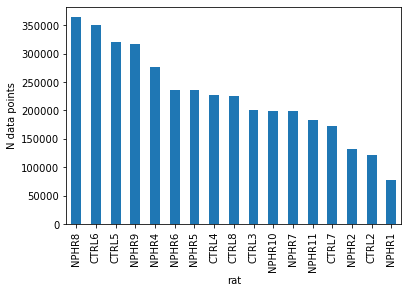

In [3]:
data, rois = collect_pruned_position_and_cp_rois_all_rats_in_path(path)
# Check if data from all rats are present in the dataframe
data['rat'].value_counts().plot.bar()
plt.xlabel('rat')
plt.ylabel('N data points')
plt.show()

### <font color='seagreen'> Collect only the data from test runs

In [4]:
test_runs_raw=data[data['run_type'] == 'T']

### <font color='seagreen'> Get ROI crossing timestamps: start of run, entry in cp, exit of cp

In [5]:
test_runs = get_roi_crossing_timestamps_for_runs_in_df(test_runs_raw, rois)

### <font color= 'seagreen'> Calculate latency to CP entry and exit

In [6]:
test_runs['latency_to_cp_entry'] = test_runs['cp_entry_timestamp'] - test_runs['start_timestamp']
test_runs['latency_to_cp_exit'] = test_runs['cp_exit_timestamp'] - test_runs['start_timestamp']
# Keep only the runs with no illumination and test illumination
pre_test_runs = test_runs[test_runs['stim_condition']== -1]
test_runs = test_runs[(test_runs['stim_condition'] == 0) | (test_runs['stim_condition'] == 3)]
test_runs['stim_condition'].unique()

array([3., 0.])

In [7]:
print(len(test_runs))

4538


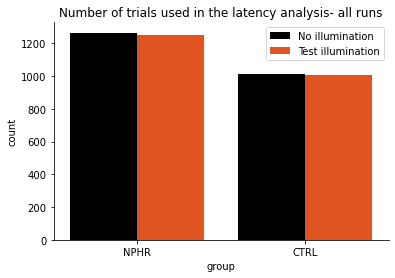

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=test_runs, x='group', hue='stim_condition',
             palette=['black', 'orangered'])
plt.legend(
    labels=['No illumination','Test illumination'],
    bbox_to_anchor=(1,1)
)
plt.title("Number of trials used in the latency analysis- all runs")
sns.despine()

In [16]:
test_runs['stim_condition'] =  test_runs['stim_condition'].astype(int).astype(str)
test_runs.groupby(['group', 'stim_condition'])['latency_to_cp_entry'].describe()

count      mean        std       min       25%  \
group stim_condition                                                    
CTRL  0               1012.0  5.204381  11.330262  1.388237  2.116150   
      3               1009.0  5.789922  10.988033  1.518170  2.249331   
NPHR  0               1265.0  4.738188   7.574014  0.991782  2.016154   
      3               1252.0  5.224217   8.643802  1.289830  2.082490   

                           50%       75%         max  
group stim_condition                                  
CTRL  0               2.744774  4.366042  215.430144  
      3               3.075059  4.828493  193.537971  
NPHR  0               2.513370  4.200499  103.747187  
      3               2.679610  4.671482  163.469965

## <font color = 'darkgreen'> 1. Latency until the choice point in all runs (timeouts included) under illumination and no illumination of test runs
***    
### Includes all runs, with all latencies values (outliers were not removed) for all illumination conditions and both groups
***

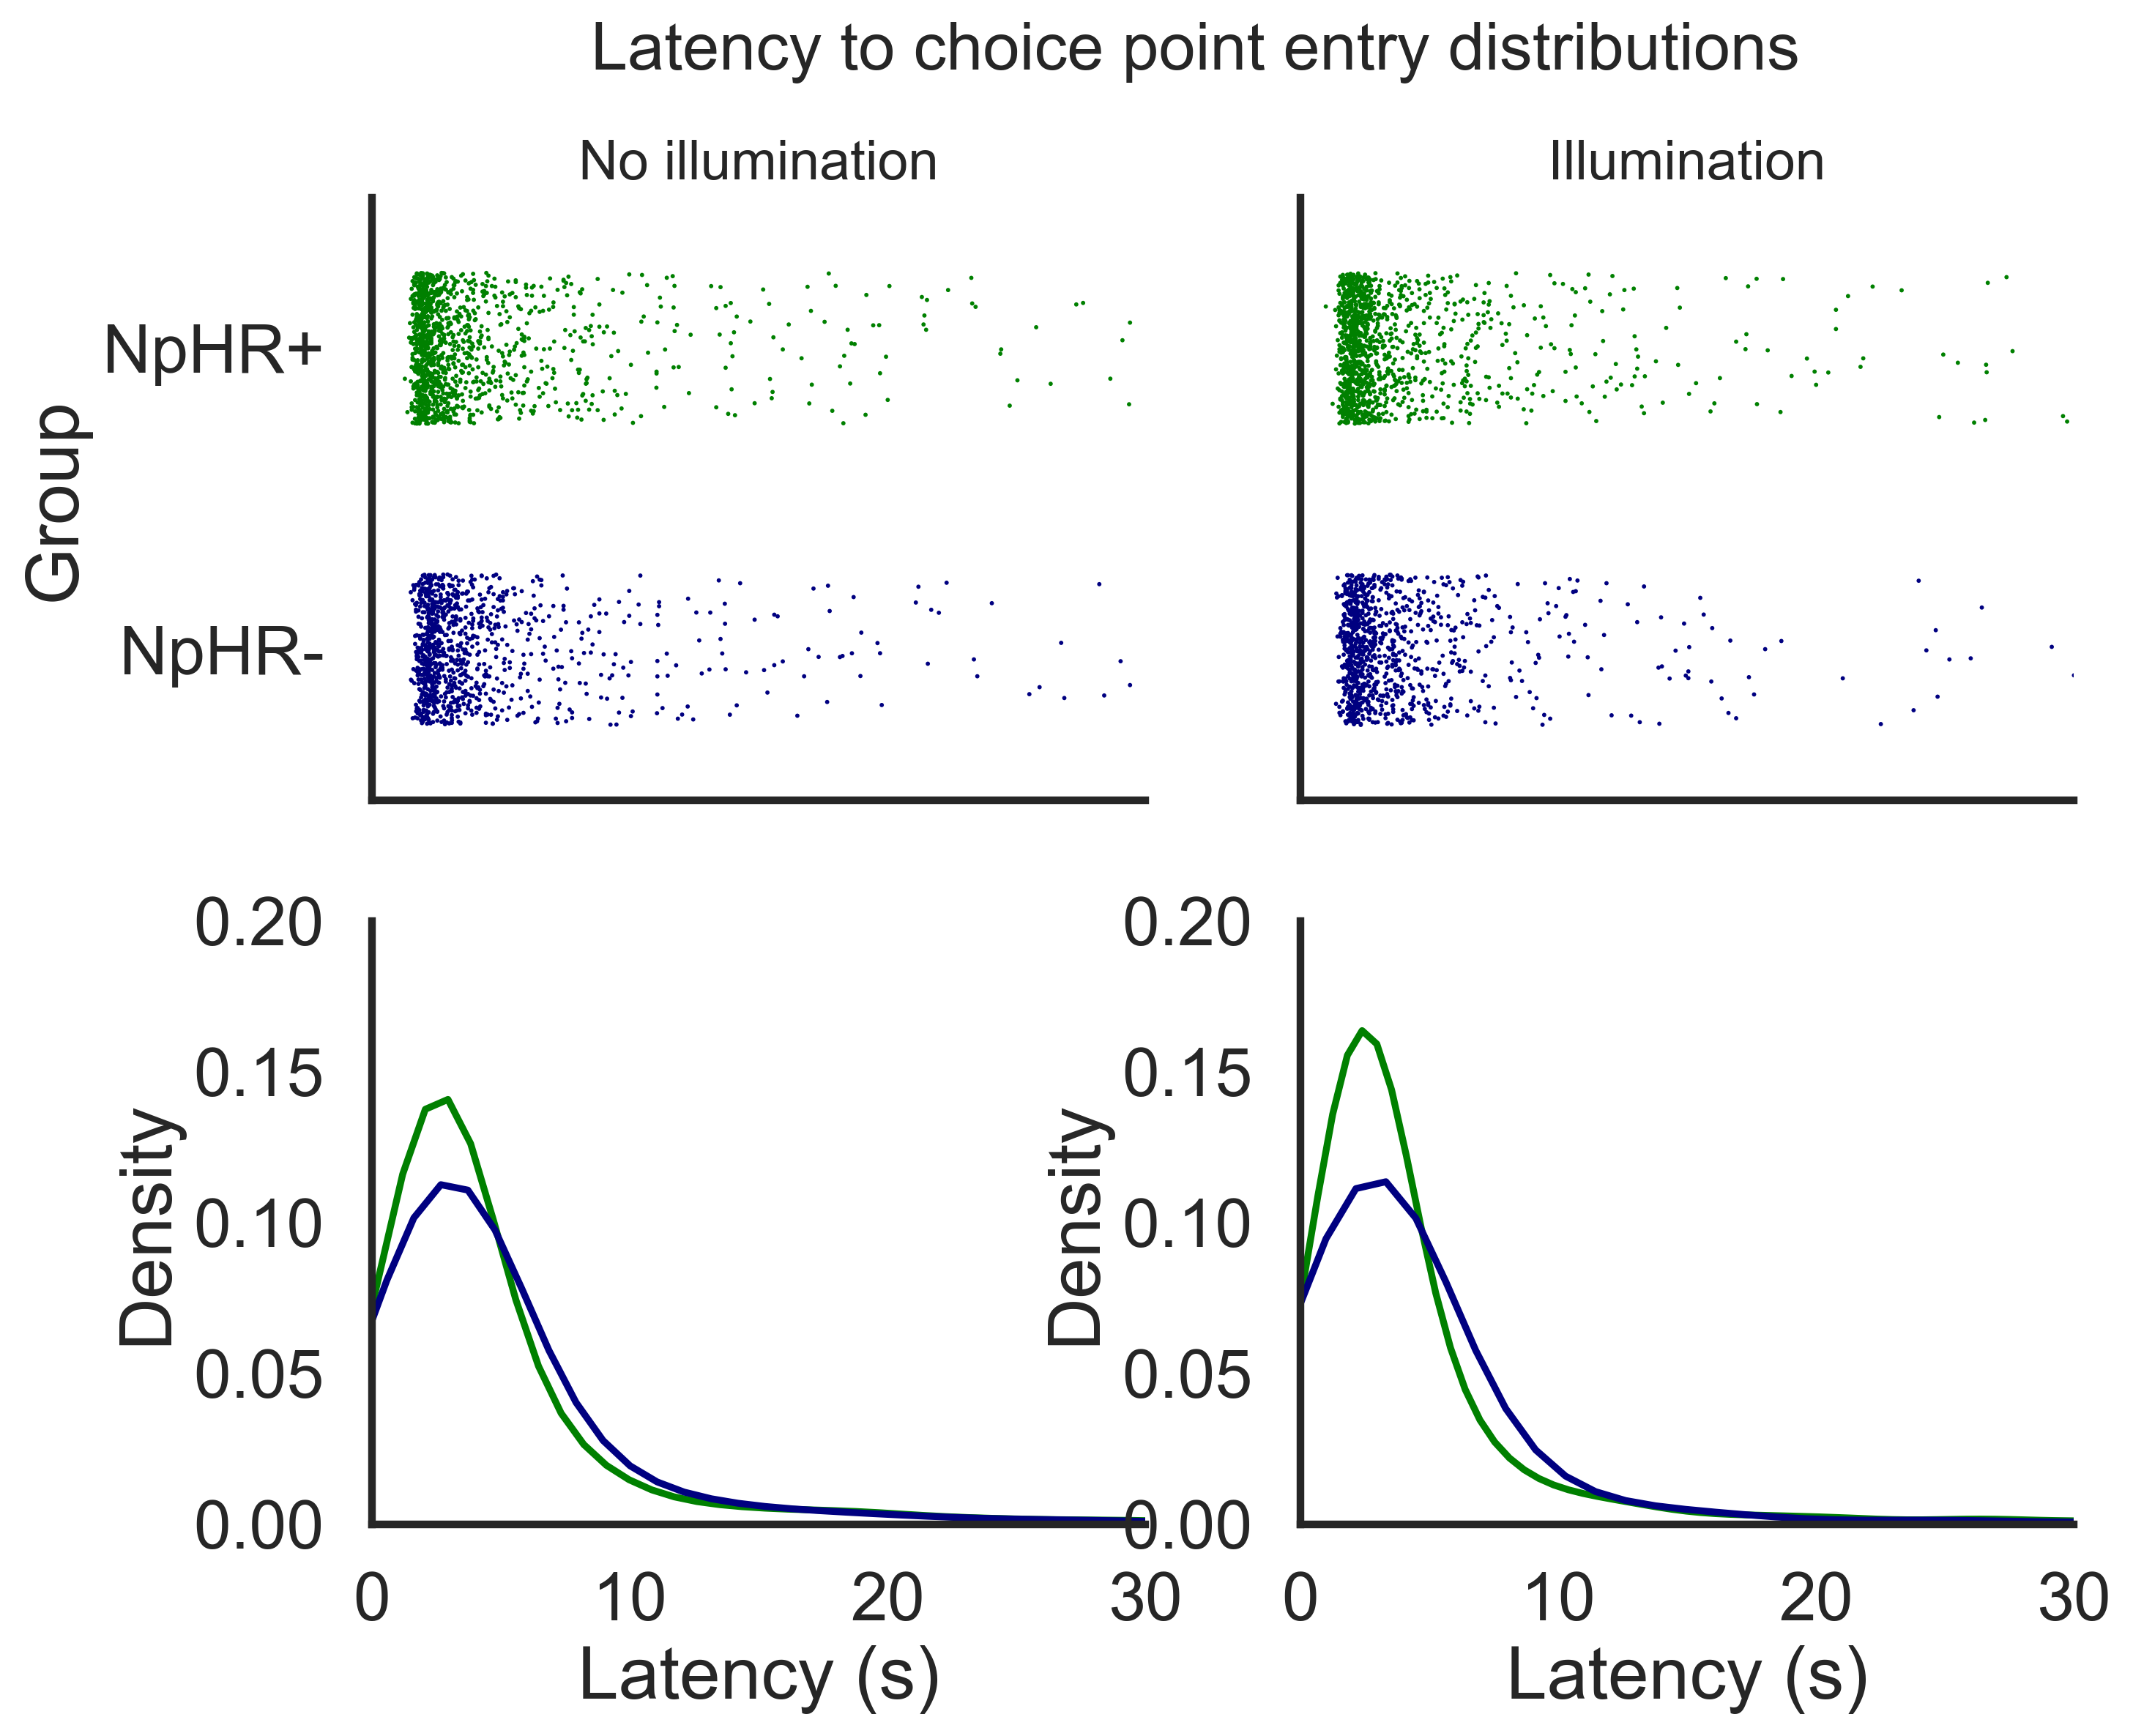

In [17]:
%run data_prep_functions.ipynb
xlim=[0,30]
ylim=[0,.2]
subplot_latency_distributions_within_conditions(test_runs, xlim, ylim)

In [18]:
quantiles = calculate_quantiles(test_runs, ['group', 'stim_condition'], 'latency_to_cp_entry')

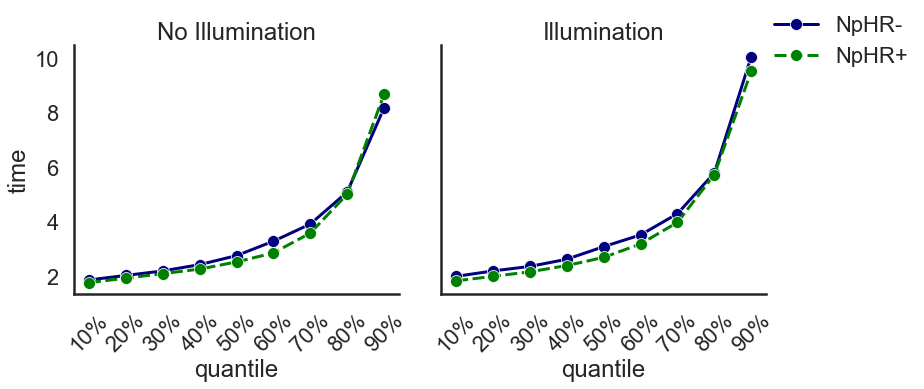

In [19]:
plot_quantile_curves_within_condition(quantiles)

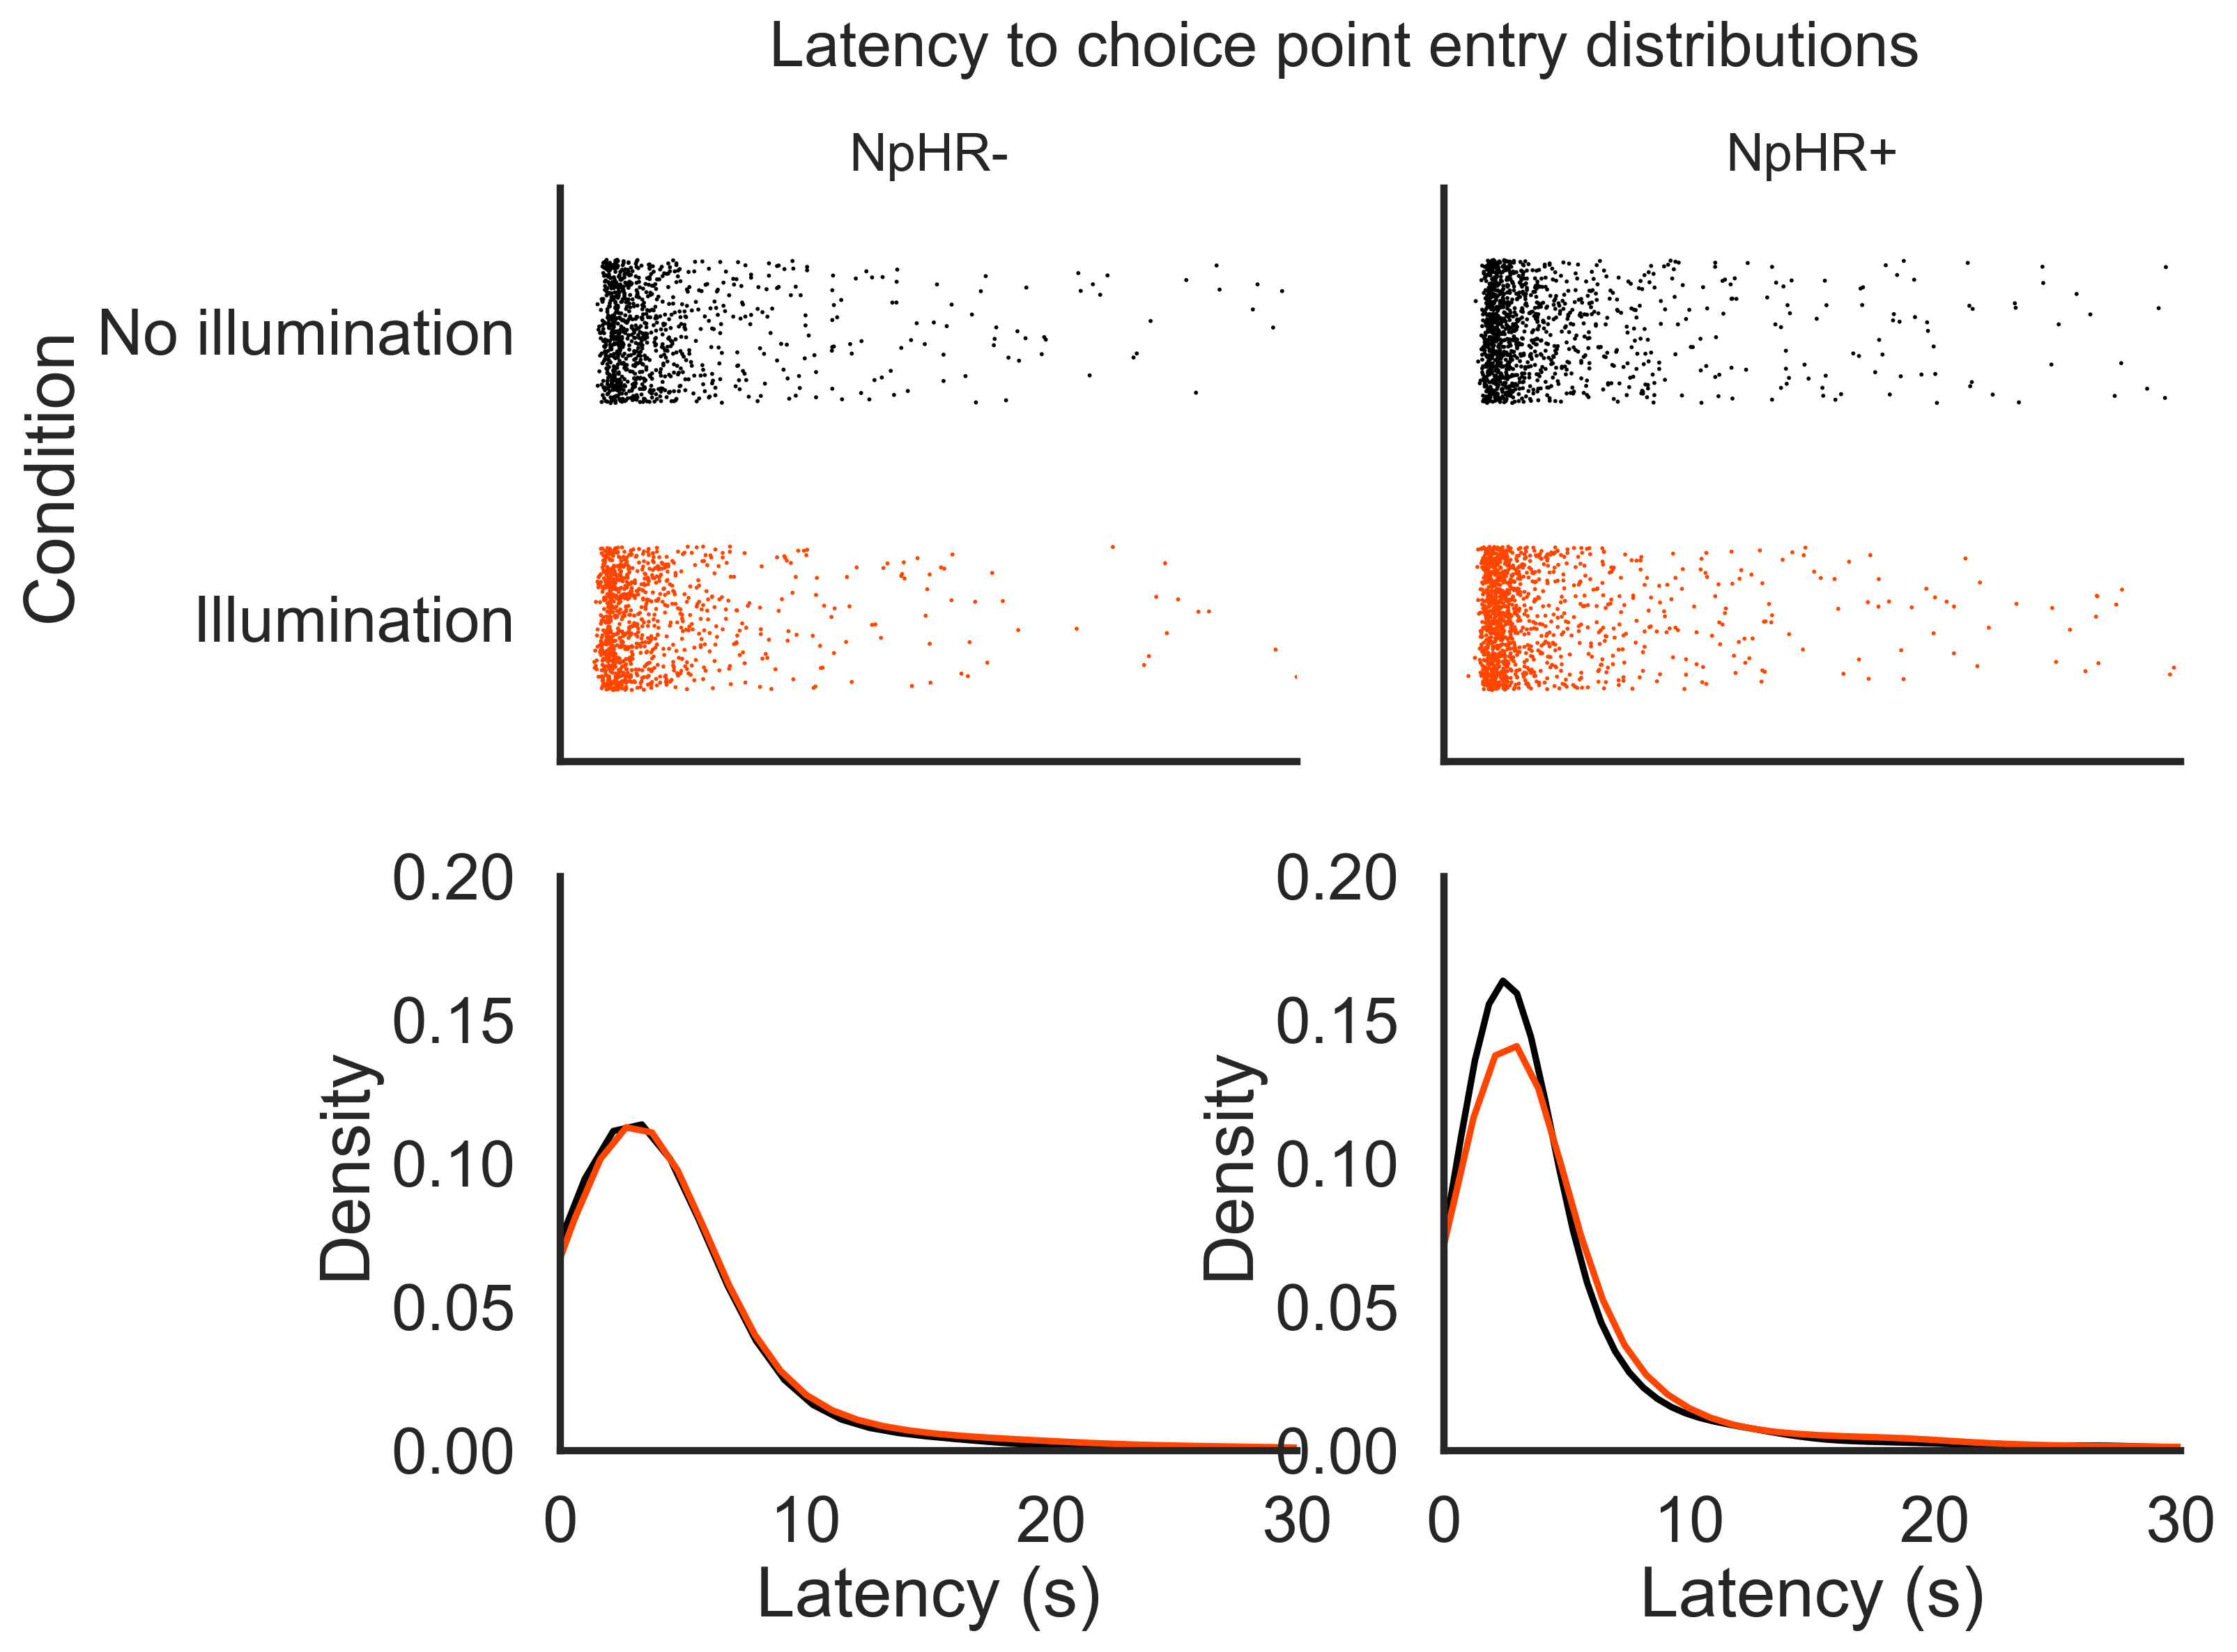

In [20]:
conditions=['0', '3']
xlim=[0,30]
ylim=[0, .2]
subplot_latency_distributions_within_groups(test_runs, conditions, xlim, ylim)

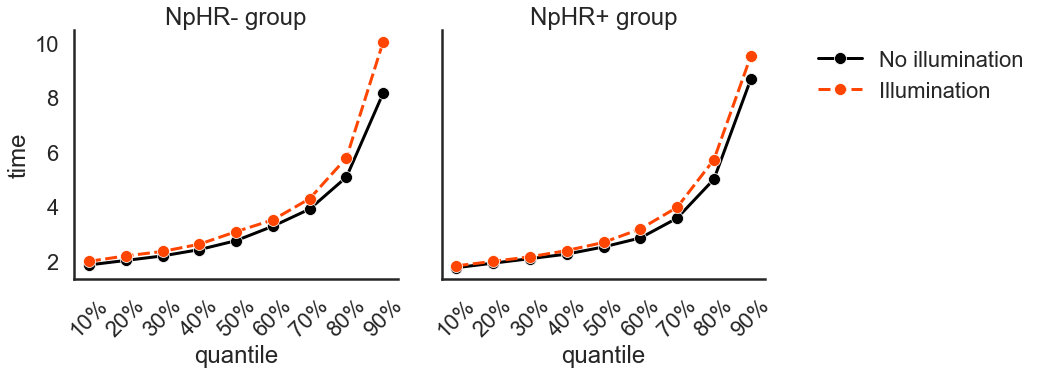

In [21]:
%run data_prep_functions.ipynb
plot_quantile_curves_within_group(quantiles)

#### All latency distributions are right skewed, with the majority of trials having half of the latencies until choice point below 2-3 seconds. However, it is noteworthy the fact that the median latency to CP in NpHR+ rats, during the Pre-illumination period is higher when compared with other conditions. It could be the effect of experience: as rats become more experienced, their latencies decrease. If this was the case, we should see similar effects on the NpHR- group - and we don't. Because the data distribution is highly skewed, I will look at the quantiles of the distributions - namely at their differences. For all the stimulation conditions (0, 3), there is not difference between the NpHR+ and NpHR- groups as they show similar quantile curves.
#### The maximum time of illumination is 15 seconds. When 15 seconds have elapsed from the start of the run, the silencing of the cingulate cortex ends, regardless of where the animal was in the maze. For runs in which the rat did not reach the choice point within this time limit, the silencing of cingulate cortex ended before the choice was expressed and so, it could have contributed for the expression of that choice. As such, we will remove test runs in which the rat did not express its choice before the 15 seconds have elapsed. We will use the choice point square limits as a reference and will collect the session and run nr in which the rat expressed its choice past 15 secs of illumination. We will then filter the currect test runs dataframe (only with position data up to choice point but not inside the CP ROI). Afterwards we will re-compare the latency to choice point distributions.


## <font color = 'darkgreen'> 2. Distributions of latencies until the choice point, upon the removal of runs without expression of choice before 15 seconds has elapsed
    
***   
#### Includes all runs below 15 seconds of latency to cp exit , for all illumination conditions and both groups. 

## <font color='gray'> What is the proportion of timeouts? Are there significant differences in the proportion of timeouts? 

In [22]:
below_15 = test_runs[test_runs['latency_to_cp_exit']<15]

In [184]:
below_15.groupby(['group', 'stim_condition'])['session'].count()

group  stim_condition
CTRL   0                  954
       3                  937
NPHR   0                 1196
       3                 1164
Name: session, dtype: int64

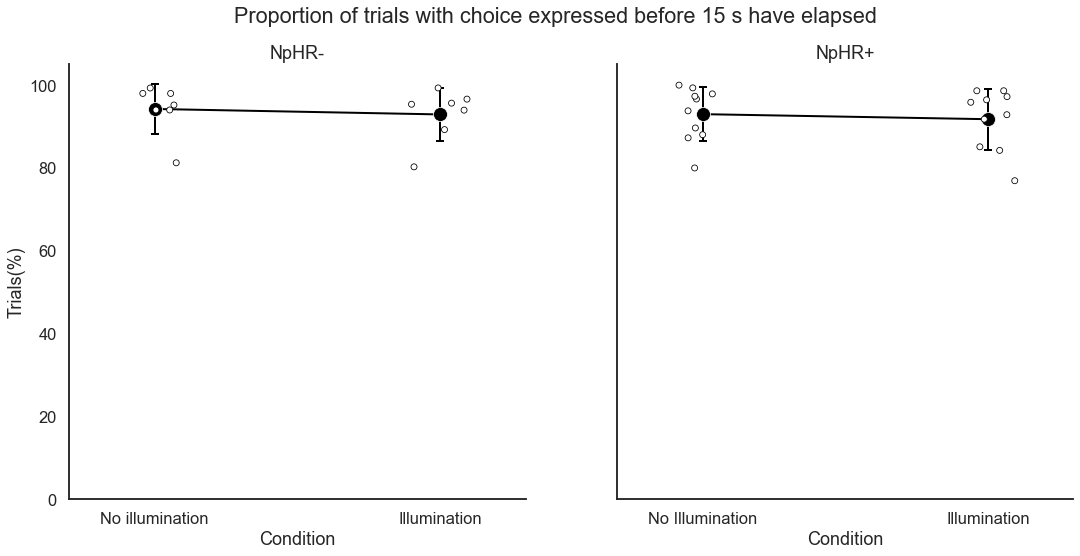

In [316]:
# Calculate the proportion of timeouts per group x rat x condition combination
prop_timeouts = below_15.groupby(['group', 'rat','stim_condition']).count()/test_runs.groupby(['group', 'rat', 'stim_condition']).count()
prop_timeouts = (prop_timeouts.reset_index())

prop_timeouts_nphr=prop_timeouts[prop_timeouts['group']=='NPHR']
prop_timeouts_ctrl=prop_timeouts[prop_timeouts['group']=='CTRL']

#Plot the proportions
fig, axes = plt.subplots(1,2, figsize=(18,8), sharey=True)
sns.set(style='white', context='talk')

sns.stripplot(
    ax=axes[0], data=prop_timeouts_ctrl*100, 
    x='stim_condition', y='run_nr',
    marker='o', size=6, edgecolor='black', 
    linewidth=.8, palette=['white']
)
sns.stripplot(
    ax=axes[1], data=prop_timeouts_nphr*100, 
    x='stim_condition', y='run_nr', 
    marker='o', size=6, edgecolor='black', 
    linewidth=.8, palette=['white']
)
sns.lineplot(
    ax=axes[0], data=prop_timeouts_ctrl*100, 
    x='stim_condition', y='run_nr',
    linewidth=2, marker='o', markersize=14, alpha=1,  
    ci='sd', err_style='bars', err_kws={'capsize':4, 'elinewidth':2, 'capthick':2},
    color='black', legend=False
)
sns.lineplot(
    ax=axes[1], data=prop_timeouts_nphr*100, 
    x='stim_condition', y='run_nr',
    linewidth=2, marker='o', markersize=14, alpha=1,
    ci='sd', err_style='bars', err_kws={'capsize':4, 'elinewidth':2, 'capthick':2}, 
    color='black', legend=False, 
)   

axes[0].set(ylim=[0,105], xlim=[-.3,1.3], 
            xlabel='Condition', ylabel='Trials(%)',
            xticklabels=['No illumination', 'Illumination'],
           title='NpHR-')
axes[1].set(ylim=[0,105], xlim=[-.3,1.3],
            xlabel='Condition', ylabel='',
            xticklabels=['No Illumination', 'Illumination'],
           title='NpHR+')

plt.suptitle('Proportion of trials with choice expressed before 15 s have elapsed\n\n\n')
sns.despine()

CTRL  0    (0.7587137222290039, 0.01563286781311035)
      3    (0.8473910093307495, 0.11631309986114502)
NPHR  0    (0.9037166237831116, 0.24055534601211548)
      3     (0.8645104169845581, 0.0862259715795517)
dtype: object

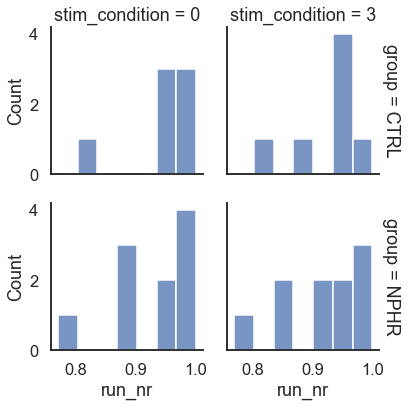

In [182]:
sns.displot(
    prop_timeouts, x="run_nr", col="stim_condition", row="group",
    facet_kws=dict(margin_titles=True), height=3)

from scipy.stats import shapiro
normality_testing = {}
for group, data in prop_timeouts.groupby(['group', 'stim_condition'])['run_nr']:
    stat, p = shapiro(data)
    normality_testing[group] = (stat, p)
normality_testing = pd.Series(normality_testing)
normality_testing

##### For one of the distributions, we rejected the null hypothesis that the distribution could have been withdrawn from a normal distribution. We will used the Wilcoxon test to determine wether the proportion of timeout trials is significantly different in each group (two-sided).

In [133]:
# Wilcoxon test on the NpHR - group
from scipy.stats import wilcoxon
ctrl_no_illum = prop_timeouts_ctrl[prop_timeouts_ctrl['stim_condition']=='0']
ctrl_illum = prop_timeouts_ctrl[prop_timeouts_ctrl['stim_condition']=='3']

w, p = wilcoxon(x=ctrl_no_illum['run_nr'], y=ctrl_illum['run_nr'])
print(w, p)

# Wilcoxon test on the NpHR+ group
nphr_no_illum = prop_timeouts_nphr[prop_timeouts_nphr['stim_condition']=='0']
nphr_illum = prop_timeouts_nphr[prop_timeouts_nphr['stim_condition']=='3']
w, p = wilcoxon(x=nphr_no_illum['run_nr'], y=nphr_illum['run_nr'])
print(w, p)

8.0 0.375
11.0 0.10546875


##### After the removal of test runs below 15 sec (upon cp exit), we are left with 92% of the sample. The distribution within and between groups is also consistent with the all runs distributions.

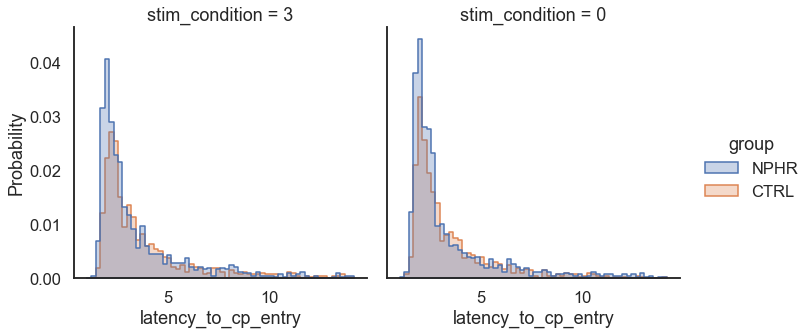

In [394]:
g = sns.displot(kind='hist', data=below_15, col='stim_condition', x='latency_to_cp_entry',
            stat='probability', hue='group',element='step',
            bins=60, alpha=.3)


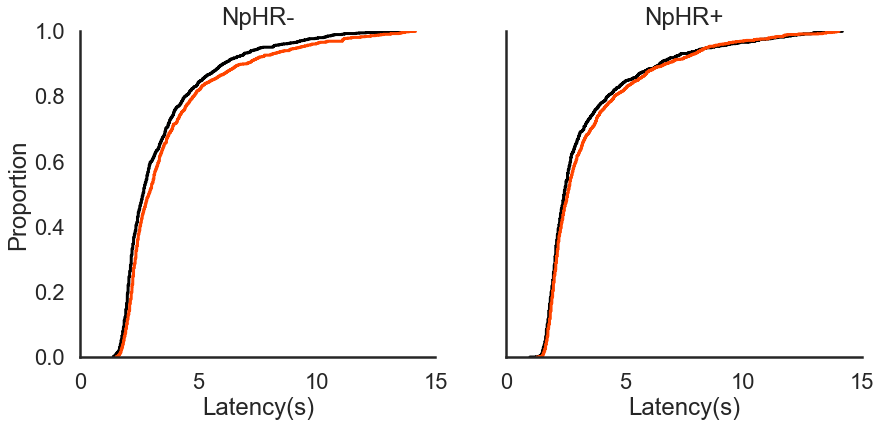

In [274]:
ctrl = below_15[below_15['group']=='CTRL']
nphr = below_15[below_15['group']=='NPHR'] 

sns.set(style='white', context='poster')
fig, axes = plt.subplots(1,2,figsize=(14,6), sharey=True)
#plt.suptitle('Cumulative distribution of Latencies\n\n\n\n\n')

sns.ecdfplot(ax=axes[0], data=ctrl, x='latency_to_cp_entry', hue='stim_condition',
             stat="proportion", palette=['orangered','black'], legend=False)

sns.ecdfplot(ax=axes[1], data=nphr, x='latency_to_cp_entry', hue='stim_condition',
             stat="proportion", palette=['orangered','black'], legend=False)


for i in [0,1]:
    axes[i].set(xlim=[0,15], ylabel='Proportion', xlabel='Latency(s)')

axes[0].set_title('NpHR-')
axes[1].set_title('NpHR+')

sns.despine()

In [261]:
# Latency difference inference for the NpHR- group
from scipy.stats import mannwhitneyu, kstest

ctrl_no = ctrl[ctrl['stim_condition']=='0']
ctrl_illum = ctrl[ctrl['stim_condition']=='3']

# Using the Mann-Whitney test to compare medians
u, p = mannwhitneyu(x=ctrl_no['latency_to_cp_entry'], y=ctrl_illum['latency_to_cp_entry'], alternative='two-sided')
print('NPHR-, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

# Using the KS test to determine if the distributions belong to different samples 
d, p = kstest(ctrl_no_illum['latency_to_cp_entry'], ctrl_illum['latency_to_cp_entry'])
print('NPHR-, KS Test result, test stat: '+str(d)+', p-value: '+str(p))

NPHR-, Mann-Whitney result, test stat: 397301.5, pvalue: 2.8901637815716922e-05
NPHR-, KS Test result, test stat: 0.11491132097845616, pvalue: 6.650318545076139e-06


In [263]:
# Latency difference inference for the NpHR+ group
from scipy.stats import mannwhitneyu
nphr_no = nphr[nphr['stim_condition']=='0']
nphr_illum = nphr[nphr['stim_condition']=='3']

# Using the Mann-Whitney test to compare medians
u, p = mannwhitneyu(x=nphr_no['latency_to_cp_entry'], y=nphr_illum['latency_to_cp_entry'], alternative='two-sided')
print('NPHR+, Mann-Whitney result, test stat: '+str(u)+', p-value: '+str(p))

# Using the KS test to determine if the distributions belong to different samples 
d,p = kstest(nphr_no['latency_to_cp_entry'], nphr_illum['latency_to_cp_entry'])
print('NPHR+, KS Test result, test stat:'+str(d)+', p-value: '+str(p))

NPHR+, Mann-Whitney result, test stat: 647980.0, pvalue: 0.003662907478026911
NPHR+, KS Test result, test stat:0.06451344113827305, pvalue: 0.01385967456348225


#### Above we find that in both experimental groups, the distribution of latencies under the two illumination conditions are significantly different. That is, the probability that they were drawn from the same population distribution is very small. 

***
## <font color = 'darkgreen'> 3. Latency until the choice point, given condition, in Test runs, grouped by outcome
***
    
#### Includes only runs with expressed choice before 15 seconds from the start have elapsed. In this step, we will repeat the previous analysis, now subdividing the runs according to outcome(correct vs. incorrect trial).

### <font color='gray'> How many trials are using in this analysis ofr each group, condition and outcome?

In [311]:
# Number of trials per group x illumination condition x outcome
below_15.groupby(['group','stim_condition','outcome'])['session'].count()

group  stim_condition  outcome
CTRL   0               0.0        174
                       1.0        780
       3               0.0        202
                       1.0        735
NPHR   0               0.0        215
                       1.0        981
       3               0.0        256
                       1.0        908
Name: session, dtype: int64

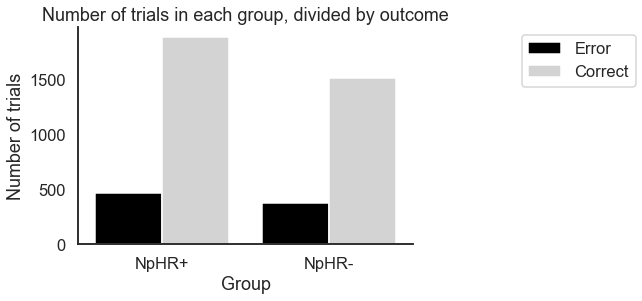

In [308]:
plt.figure(figsize=(6,4))
sns.countplot(data=below_15, x='group',hue='outcome', palette=['black', 'lightgray'])

plt.legend(labels=['Error', 'Correct'], bbox_to_anchor=(1.3,1))
plt.xlabel('Group')
plt.ylabel('Number of trials')
plt.title("Number of trials in each group, divided by outcome")
plt.xticks(ticks=[0,1], labels=['NpHR+', 'NpHR-'])
sns.despine()

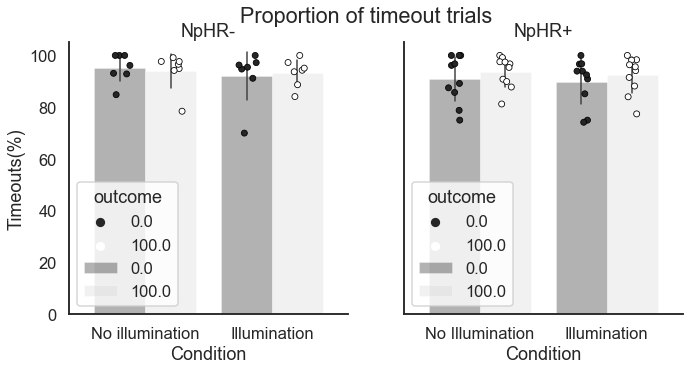

In [306]:
# Calculate the proportion of timeouts per group x rat x condition combination
prop_timeouts = below_15.groupby(['group', 'rat','stim_condition','outcome']).count()/test_runs.groupby(
    ['group', 'rat', 'stim_condition', 'outcome']).count()
prop_timeouts = (prop_timeouts.reset_index())

prop_timeouts_nphr=prop_timeouts[prop_timeouts['group']=='NPHR']
prop_timeouts_ctrl=prop_timeouts[prop_timeouts['group']=='CTRL']

#Plot the proportions
fig, axes = plt.subplots(1,2, figsize=(11,5), sharey=True)
sns.set(style='white', context='talk')


sns.stripplot(
    ax=axes[0], data=prop_timeouts_ctrl*100, x='stim_condition', y='run_nr', hue='outcome',
    marker='o', size=6, edgecolor='black', color='white', linewidth=.8, dodge=True, jitter=.2
)
sns.stripplot(
    ax=axes[1], data=prop_timeouts_nphr*100, x='stim_condition', y='run_nr', hue='outcome',
    marker='o', size=6, edgecolor='black', linewidth=.8, color='white', dodge=True
)
sns.barplot(
    ax=axes[0], data=prop_timeouts_ctrl*100, 
    x='stim_condition', y='run_nr', hue='outcome',
    linewidth=1, color='black', alpha=.3, palette=['black', 'lightgray'], 
    ci='sd', errwidth=1.5
)
sns.barplot(
    ax=axes[1], data=prop_timeouts_nphr*100, 
    x='stim_condition', y='run_nr', hue='outcome',
    linewidth=1, color='black', alpha=.3, palette=['black', 'lightgray'], 
    ci='sd', errwidth=1.5
)

axes[0].set(ylim=[0,105], xlim=[-.6,1.6], 
            xlabel='Condition', ylabel='Timeouts(%)',
            xticklabels=['No illumination', 'Illumination'],
           title='NpHR-')
axes[1].set(ylim=[0,105], xlim=[-.6,1.6],
            xlabel='Condition', ylabel='',
            xticklabels=['No Illumination', 'Illumination'],
           title='NpHR+')

plt.suptitle('Proportion of timeout trials\n\n\n')
sns.despine()

##### As expected, we have more correct trials than error trials, virtue of the high performance levels during the plateau

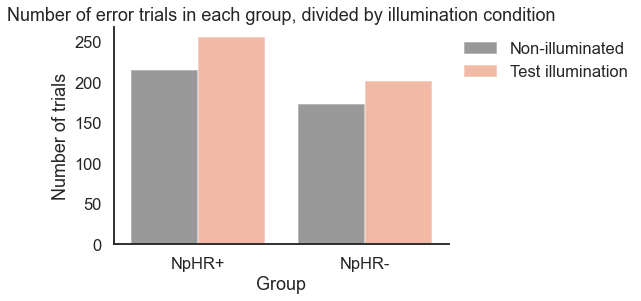

In [320]:
plt.figure(figsize=(6,4))
sns.countplot(data=errors, x='group', hue='stim_condition', hue_order=['0', '3'],
             palette=['Black', 'orangered'], alpha=.4)
plt.legend(
    labels=['Non-illuminated', 'Test illumination'],
    bbox_to_anchor=(1,1),
    frameon=False
)
plt.xlabel('Group')
plt.ylabel('Number of trials')
plt.title("Number of error trials in each group, divided by illumination condition")
plt.xticks(ticks=[0,1], labels=['NpHR+', 'NpHR-'])
sns.despine()

##### The distribution of errors within condition and group is very similar.

### <font color='darkgreen'> 3.1. Analysis of latency to choice point in error trials for the NpHR+ group
***

In [329]:
errors=below_15[below_15['outcome']==0]
nphr_errors = errors[errors['group']=='NPHR']
ctrl_errors=errors[errors['group']=='CTRL']
nphr_errors.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962
19,2019-08-09T11_26_15,NPHR1,22.0,1301.300608,T,3,0.0,NPHR,1303.369702,1304.408230,2.069094,3.107622
27,2019-08-09T11_26_15,NPHR1,40.0,2385.598310,T,3,0.0,NPHR,2388.177114,2388.857050,2.578803,3.258739


Text(0.5, 1.0, 'NpHR+')

<Figure size 864x576 with 0 Axes>

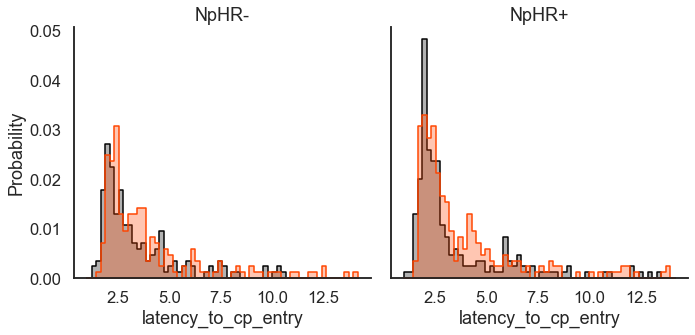

In [373]:
sns.set(style='white', context='talk')
plt.figure(figsize=(12,8))
plt.suptitle('Latency distributions in error trials\n')
g = sns.displot(kind='hist', data=errors, col='group', x='latency_to_cp_entry',
            stat='probability', hue='stim_condition', col_order=['CTRL', 'NPHR'],element='step',
                palette=['orangered','black'], bins=60, alpha=.3, legend=False)
axes = g.axes.flatten()
axes[0].set_title("NpHR-")
axes[1].set_title("NpHR+")

[Text(0.5, 0, 'Latency(s)')]

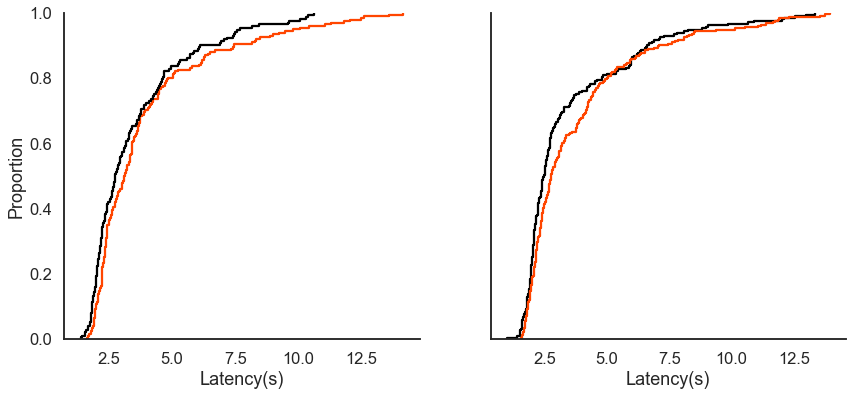

In [389]:
fig, axes = plt.subplots(1,2,figsize=(14,6), sharey=True)
sns.ecdfplot(ax=axes[0], data=ctrl_errors, x='latency_to_cp_entry', hue='stim_condition',
             stat="proportion", palette=['black', 'orangered'], legend=False)
sns.ecdfplot(ax=axes[1], data=nphr_errors, x='latency_to_cp_entry', hue='stim_condition',
             stat="proportion", palette=['orangered','black'], legend=False)
sns.despine()
axes[0].set(xlabel='Latency(s)')
axes[1].set(xlabel='Latency(s)')

In [ ]:
%run data_prep_functions.ipynb
xlim=[0,15]
ylim=[0,1]
conditions=['0', '3']
subplot_latency_distributions_within_groups(errors, conditions, xlim, ylim)

In [ ]:
plot_quantile_curves_within_group(error_quantiles)

In [ ]:
sns.set(style="white", context='talk')
plt.figure(figsize=(12,10), dpi=300)

flierprops=dict(marker='o', markerfacecolor='white', markersize=3, linewidth=.2)
a = sns.boxplot(
    data=errors, x='latency_to_cp_entry', y='stim_condition', hue='rat',
    linewidth=.6, flierprops=flierprops, boxprops=dict(alpha=.7), 
    hue_order=['CTRL2', 'CTRL3', 'CTRL4', 'CTRL5','CTRL6',
           'NPHR1', 'NPHR2', 'NPHR4', 'NPHR5', 'NPHR6', 'NPHR7', 'NPHR8' ]
)
plt.xlabel('Latency(s)')
#plt.ylabel(' ')
plt.xlim([0, 15])
#plt.ylim([-.5,.5])
plt.title('Latency to choice point in error trials')
sns.despine()

### <font color='darkgreen'> 5.2. Correct trials
***

In [ ]:
xlim=[0,15]
ylim=[0,.4]
subplot_latency_distributions_within_conditions(corrects, xlim, ylim)

In [ ]:
correct_quantiles = calculate_quantiles(corrects, ['group', 'stim_condition'], 'latency_to_cp_entry')

In [ ]:
plot_quantile_curves_within_condition(correct_quantiles)

In [ ]:
%run data_prep_functions.ipynb
xlim=[0,15]
ylim=[0,.4]
conditions=['0', '3']
subplot_latency_distributions_within_groups(corrects, conditions, xlim, ylim)

In [ ]:
plot_quantile_curves_within_group(correct_quantiles)

***
## <font color='darkgreen'> 6. Latency to choice pointduring test runs of the pre-illumination period (below 15 secs)
***

In [ ]:
pre_test = test_runs_raw[test_runs_raw['stim_condition'] == -1]
pre_test_runs = get_roi_crossing_timestamps_for_runs_in_df(pre_test, rois)
pre_test_runs.head(3)

### <font color= 'seagreen'> Calculate latency to CP entry and exit

In [ ]:
pre_test_runs['latency_to_cp_entry'] = pre_test_runs['cp_entry_timestamp'] - pre_test_runs['start_timestamp']
pre_test_runs['latency_to_cp_exit'] = pre_test_runs['cp_exit_timestamp'] - pre_test_runs['start_timestamp']
pre_test_runs.head(3)

### <font color= 'seagreen'> Remove runs with latency to CP exit < 15 secs

In [ ]:
pre_test_runs = pre_test_runs[pre_test_runs['latency_to_cp_exit'] <15]
pre_test_runs.groupby(['group', 'outcome']).size()

In [ ]:
plt.figure(figsize=(6,4), dpi=300)
sns.set(context='talk', style='white')
flierprops=dict(marker='o', markerfacecolor='white', markersize=2, linewidth=.2)
sns.boxplot(
    data=pre_test_runs, x='latency_to_cp_entry', y='group', 
    dodge=True, linewidth=.6,
    palette=['deepskyblue', 'navy'], boxprops={'alpha':.7},
    flierprops=flierprops
)
plt.xlim([0,15])
plt.ylim([-.8,1.8])
plt.xlabel('Time(s)')
plt.title('Latency to choice point during the pre-illumination period')
#plt.yticks(labels='', ticks=[])
plt.legend(handles=[ctrl_patch, nphr_patch], bbox_to_anchor=(1.4,.73), frameon=False)   
sns.despine()

In [ ]:
pre_errors = pre_test_runs[pre_test_runs['outcome']==0]

sns.kdeplot(data = pre_errors[pre_errors['group']=='CTRL'], x='latency_to_cp_entry', color='navy')
sns.kdeplot(data = pre_errors[pre_errors['group'] == 'NPHR'], x = 'latency_to_cp_entry', color='deepskyblue')
sns.despine()

In [ ]:
pre_quantiles = calculate_quantiles(pre_test_runs, ['group', 'stim_condition'], 'latency_to_cp_entry')
sns.set(style='white', context='poster')
g = sns.relplot(
        data=pre_quantiles, kind='line',
        x='quantile', y='time', hue='group',
        markers=['o', 'o'], style='group', 
        palette=['midnightblue', 'deepskyblue'],
        col='stim_condition', height=5, aspect=1.1, 
        legend=False   
    )
g.set_xticklabels(labels=quantiles['quantile'].unique(), rotation=45)
#plt.yticks(labels=range(0,21,2), ticks=range(0,21,2))
    
plt.legend(['NpHR-', 'NpHR+'], frameon=False, bbox_to_anchor=(1.6,1))
sns.despine()

In [ ]:
sns.set(style="white", context='talk')
plt.figure(figsize=(10,6), dpi=300)

flierprops=dict(marker='o', markerfacecolor='white', markersize=2, linewidth=.2)
#colors = ['mediumaquamarine', 'midnightblue']
a = sns.boxplot(
    data=pre_test_runs, x='latency_to_cp_entry', y='rat',
    linewidth=.6, flierprops=flierprops, boxprops=dict(alpha=.7), 
    order=['CTRL2', 'CTRL3', 'CTRL4', 'CTRL5', 'CTRL6',
           'NPHR1', 'NPHR2', 'NPHR4', 'NPHR5', 'NPHR6', 'NPHR7', 'NPHR8' ]
)
plt.xlabel('Latency(s)')
#plt.ylabel(' ')
plt.xlim([0, 15])
#plt.ylim([-.5,.5])
plt.title('Latency to choice point during the pre-illumination test runs')
sns.despine()

## <font color='darkgreen'> 7. Latency to choice point during the first session only (below 15 secs)
***
    
### I will analyze the latency to choice point distributions for th first session only, within each condition and group.
### The anatomy work so far as shown that NpHR+ rats demonstrate a lesion/scaring in the CG, where the NpHR is activated. If this lesions occurr due to a destruction of tissue upon the NpHR activation, then, we can assume that the first trials can have intersting information regarding the latency distribution. However, we do not know when this lesion develops (e.g. could be during the first trial, could be after 5 sessions, 10 sessions etc.).

In [ ]:
firsts = test_runs.groupby(['rat', 'stim_condition']).head(10)
firsts = firsts[firsts['latency_to_cp_exit']<15]
firsts.groupby(['group', 'stim_condition']).count()

In [ ]:
subplot_latency_distributions_within_conditions(firsts)

In [ ]:
subplot_latency_distributions_within_groups(firsts)

In [ ]:
first_quantiles = calculate_quantiles(firsts, ['group', 'stim_condition'], 'latency_to_cp_entry')
first_quantiles_rat = calculate_quantiles(firsts, ['group', 'rat', 'stim_condition'], 'latency_to_cp_entry')

In [ ]:
plot_quantile_curves_within_condition(first_quantiles)

In [ ]:
plot_quantile_curves_within_group(first_quantiles)